In [2]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
from scipy import spatial
import json
from matplotlib import cm as CM
from image import *
from model import CSRNet
import torch
import tqdm
%matplotlib inline

In [3]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    #Generates a density map using Gaussian filter transformation
    
    density = np.zeros(gt.shape, dtype=np.float32)
    
    gt_count = np.count_nonzero(gt)
    
    if gt_count == 0:
        return density

    # FInd out the K nearest neighbours using a KDTree
    
    pts = np.array(list(zip(np.nonzero(gt)[1].ravel(), np.nonzero(gt)[0].ravel())))
    leafsize = 2048
    
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    
    # query kdtree
    distances, locations = tree.query(pts, k=4)

        
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        
        #Convolve with the gaussian filter
        
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    
    return density

In [7]:
#set the root to the Shanghai dataset you download
root = '.\\data'

In [8]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'ShanghaiA\\train_data','images')
part_A_test = os.path.join(root,'ShanghaiA\\test_data','images')
part_B_train = os.path.join(root,'ShanghaiB\\train_data','images')
part_B_test = os.path.join(root,'ShanghaiB\\test_data','images')
path_sets = [part_A_train,part_A_test]

In [9]:
# List of all image paths

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)
print(len(img_paths))

482


In [11]:
from tqdm import tqdm

i = 0
for img_path in tqdm(img_paths):
        
    
    # Load sparse matrix
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    
    #Read image
    img= plt.imread(img_path)
    
    # Create a zero matrix of image size
    k = np.zeros((img.shape[0],img.shape[1]))
    
    gt = mat["image_info"][0,0][0,0][0]
    
    #Generate hot encoded matrix of sparse matrix
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    
    # generate density map
    k = gaussian_filter_density(k)
    
    # File path to save density map
    file_path = img_path.replace('.jpg','.h5').replace('images','ground_truth')
    
    
    with h5py.File(file_path, 'w') as hf:
            hf['density'] = k
    


0%|          | 1/482 [00:54<7:13:55, 54.13s/it]


KeyboardInterrupt: 

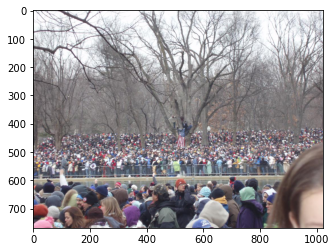

In [12]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

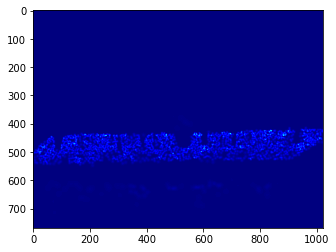

In [13]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [14]:
np.sum(groundtruth)# don't mind this slight variation

1543.841

In [ ]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [ ]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [ ]:
for img_path in img_paths:
    print(img_path)
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k